In [1]:
from utilities import *

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import StratifiedKFold,  RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from scipy.stats import randint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import optuna
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from skorch import NeuralNetClassifier

In [2]:
X = np.load("saves/train_features_Khened.npy")
X_test = np.load("saves/test_features_Khened.npy")
y = np.load("saves/categories.npy")
y = y.astype(np.int64)
print(f"Number of features: {X.shape[1]}")

Number of features: 20


In [3]:
TRAIN = False

In [4]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_test = scaler.transform(X_test)

In [6]:
svm_params_grid = {
    'C': [1, 10, 100, 1000],
    'gamma': [0.001, 0.0001],
    'kernel': ['rbf']
}

rf_params_grid = {
    "n_estimators": [1000],
    "max_depth": [None],
    "min_samples_split": randint(5, 30),
    "min_samples_leaf": randint(5, 30),
    "max_features": ["sqrt", "log2", None],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False]
}

gnb_params_grid = {
    "var_smoothing": [1e-9, 1e-10,1e-8]
}

In [7]:
clfs = []
if TRAIN:
    for clf, params, name in zip([SVC(random_state=0,probability=True), RandomForestClassifier(random_state=0), GaussianNB()], [svm_params_grid, rf_params_grid, gnb_params_grid], ["svm", "rf", "gnb"]):
        print(f"Training {name}")
        if name == "rf":
            grid = RandomizedSearchCV(clf, params, n_iter=50, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
        else:
            grid = GridSearchCV(clf, params, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1,)
        grid.fit(X, y)
        print(f"Best parameters: {grid.best_params_}")
        print(f"Best score: {grid.best_score_}")
        clfs.append((name,grid.best_estimator_))
        print(f"Done {name}")
        print("\n")

else:
    svm = SVC(C=100, gamma=0.001, kernel='rbf', probability=True, random_state=0)
    rf = RandomForestClassifier(n_estimators=1000, max_depth=None, min_samples_split=10, min_samples_leaf=7, max_features="log2", criterion='entropy', bootstrap=True, random_state=0)
    gnb = GaussianNB(var_smoothing=1e-9)
    clfs = [('svm', svm), ('rf', rf), ('gnb', gnb)]

In [8]:
hidden_options = ["100-100", "100-100-100"]

def objective(trial, X, y):
    
    alpha = trial.suggest_float("alpha", 1e-6, 1e-2, log=True)
    solver = trial.suggest_categorical("solver", ["adam", "lbfgs"])
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    learning_rate = trial.suggest_categorical("learning_rate", ["constant", "adaptive"])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    early_stopping = trial.suggest_categorical("early_stopping", [True, False])
    
    hidden_key = trial.suggest_categorical("hidden_layer_sizes", hidden_options)
    hidden_layer_sizes = tuple(map(int, hidden_key.split("-")))


    clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        alpha=alpha,
        solver=solver,
        activation=activation,
        learning_rate=learning_rate,
        learning_rate_init=learning_rate_init,
        early_stopping=early_stopping,
        max_iter=1000,
        random_state=0
    )

    scores = cross_val_score(
        clf,
        X,
        y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0),
        scoring='accuracy'
    )
    return scores.mean()

In [9]:
if TRAIN:

    study = optuna.create_study(direction="maximize")
    study.optimize(lambda t:objective(t,X=X,y=y), n_trials=10)

    best_params = study.best_params
    best_params["hidden_layer_sizes"] = tuple(map(int, best_params["hidden_layer_sizes"].split("-")))
    
    print("Best params:", best_params)
    print(f"Best accuracy: {study.best_value:.4f}")
    
    best_mlp = MLPClassifier(**best_params, max_iter=1000, random_state=0)

    if len(clfs) == 3:
        clfs.append(('mlp', best_mlp))
    else:
        clfs[3] = ('mlp', best_mlp)

else:
    params = {'alpha': 3.077003950417802e-06, 'solver': 'adam', 'activation': 'tanh', 'learning_rate': 'constant', 'learning_rate_init': 0.015093070624075637, 'early_stopping': False, 'hidden_layer_sizes': (100,100)}
    best_mlp = MLPClassifier(**params, max_iter=1000, random_state=0)
    clfs.append(('mlp', best_mlp))

In [10]:
for clf in clfs:
    cross_score = cross_val_score(clf[1], X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
    print(f"{clf[0]}: {cross_score.mean():.4f} +/- {cross_score.std():.4f}")

svm: 0.9600 +/- 0.0490
rf: 0.9500 +/- 0.0548
gnb: 0.9500 +/- 0.0632
mlp: 0.9400 +/- 0.0583


In [14]:
mask = (y == 1) | (y == 2)
X_expert = X[mask][:, 16:20].astype(np.float32)
y_expert = y[mask].astype(np.int64)

if TRAIN:
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda t:objective(t,X=X_expert,y=y_expert), n_trials=10)

    print("Best params:", study.best_params)
    print(f"Best accuracy: {study.best_value:.4f}")

    best_params = study.best_params
    best_params["hidden_layer_sizes"] = tuple(map(int, best_params["hidden_layer_sizes"].split("-")))
    best_mlp_2 = MLPClassifier(**best_params, max_iter=1000, random_state=0)
    
else:
    params = {'hidden_layer_sizes': (100, 100, 100),'alpha': 0.00022368589093655925, 'solver': 'adam', 'activation': 'tanh', 'learning_rate': 'adaptive', 'learning_rate_init': 0.011809196731031717, 'early_stopping': False}
    best_mlp_2 = MLPClassifier(**params, max_iter=1000, random_state=0)
    
best_mlp_2.fit(X_expert, y_expert)
cross_score = cross_val_score(best_mlp_2, X_expert, y_expert, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
print("Best MLP expert score:", cross_score.mean(), "+/-", cross_score.std())
    

Best MLP expert score: 0.975 +/- 0.049999999999999996


In [15]:
eclf_soft = VotingClassifier(estimators=clfs, voting='soft')
eclf_hard = VotingClassifier(estimators=clfs, voting='hard')
scores_soft = cross_val_score(eclf_soft, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
scores_hard = cross_val_score(eclf_hard, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=0), n_jobs=-1)
print(f"Cross-validation Accuracy of soft voting :  {scores_soft.mean():.4f} +/- {scores_soft.std():.4f}")
print(f"Cross-validation Accuracy of hard voting :  {scores_hard.mean():.4f} +/- {scores_hard.std():.4f}")

Cross-validation Accuracy of soft voting :  0.9600 +/- 0.0374
Cross-validation Accuracy of hard voting :  0.9700 +/- 0.0400


In [16]:
def stage1(X, y, clfs, voting='hard'):
    eclf = VotingClassifier(estimators=clfs, voting=voting)
    eclf = eclf.fit(X, y)
    return eclf

def stage2(X, y, X_test, y_pred, mlp_expert):
    X_train = X[(y == 1.) | (y == 2.)]
    X_train = X_train[:,16:20]
    round2 = []
    for i,pred in enumerate(y_pred):
        if pred == 1 or pred == 2:
            round2.append(i)
    if len(round2) == 0:
        return y_pred
    Xround2 = X_test[round2][:,16:20]
    
    mlp = mlp_expert
    mlp.fit(X_train, y[(y == 1) | (y == 2)])
    y_pred2 = mlp.predict(Xround2)
    y_pred[round2] = y_pred2
    return y_pred

def predictions(X, y, X_test, clfs, mlp_expert, voting='hard'):
    clf = stage1(X, y, clfs, voting)
    y_pred = clf.predict(X_test)
    y_pred = stage2(X, y, X_test, y_pred, mlp_expert)
    return y_pred

Text(0.5, 1.0, 'Confusion Matrix')

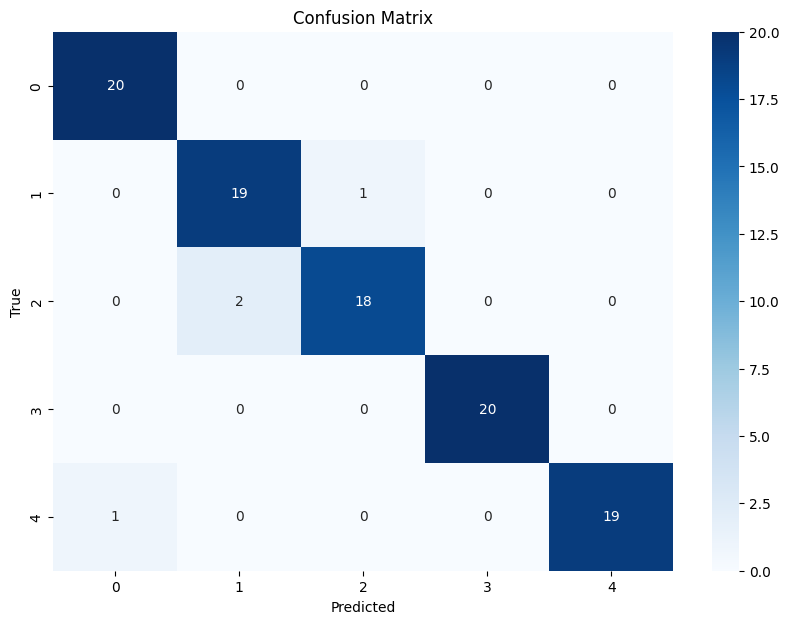

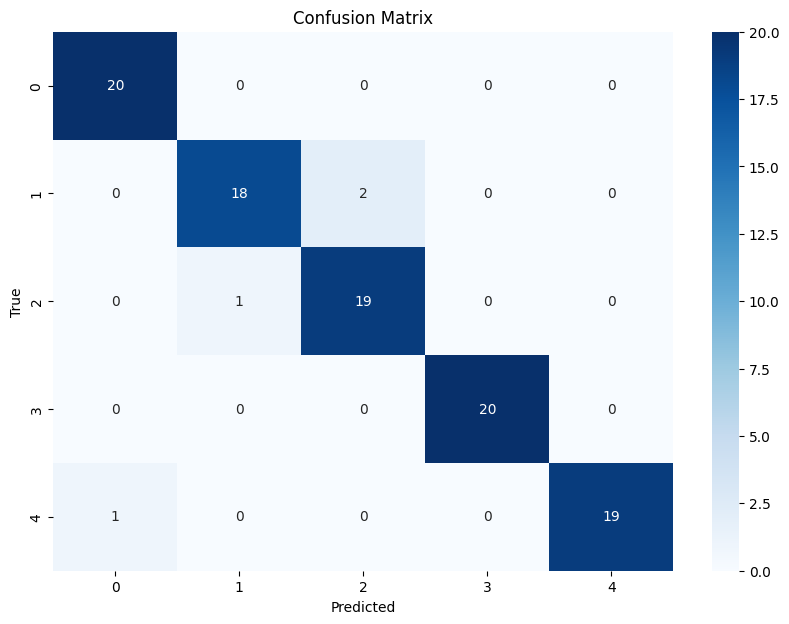

In [17]:
cms = np.zeros((len(set(y)), len(set(y)),2), dtype=int)
eclf = VotingClassifier(estimators=clfs, voting='hard')

kf = StratifiedKFold(n_splits=5)
for train_index, test_index in kf.split(X, y):
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y[train_index], y[test_index]

    eclf.fit(X_train, y_train)
    y_pred = eclf.predict(X_val)
    cm1 = confusion_matrix(y_val, y_pred)
    y_pred = stage2(X_train, y_train, X_val, y_pred, mlp_expert=best_mlp_2)
    cm2 = confusion_matrix(y_val, y_pred)
    cms[:,:,0] += cm1
    cms[:,:,1] += cm2 
    
plt.figure(figsize=(10, 7))
sns.heatmap(cms[:,:,0], annot=True, fmt='d', cmap='Blues', xticklabels=set(y), yticklabels=set(y))
#sns.heatmap(cms[1:3, 1:3, 0], annot=True, cmap="Reds")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.figure(figsize=(10, 7))
sns.heatmap(cms[:,:,1], annot=True, fmt='d', cmap='Blues', xticklabels=set(y), yticklabels=set(y))
#sns.heatmap(cms[1:3, 1:3, 1], annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

In [18]:
y_pred = predictions(X, y, X_test, clfs, mlp_expert=best_mlp_2, voting="hard")

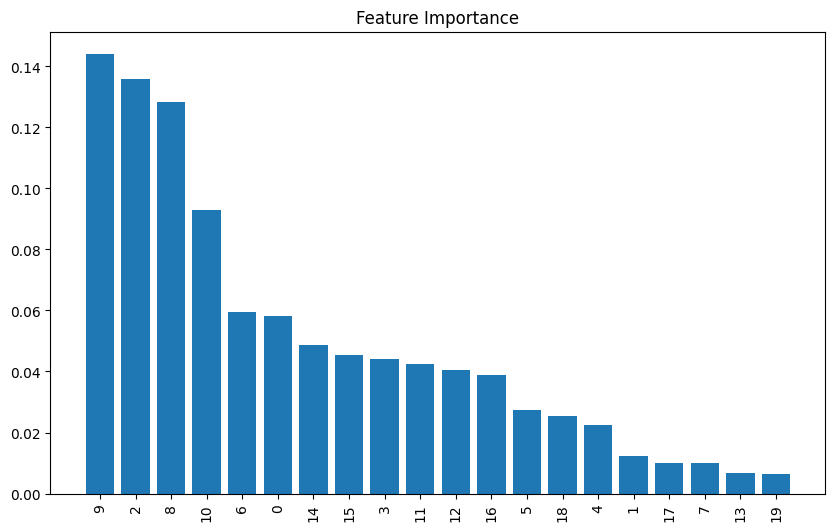

In [19]:
rf = clfs[1][1]

rf.fit(X, y)

importances = rf.feature_importances_

index = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.title("Feature Importance")
plt.bar(range(len(importances)), importances[index], align="center")
plt.xticks(range(len(importances)),index, rotation=90)
plt.show()

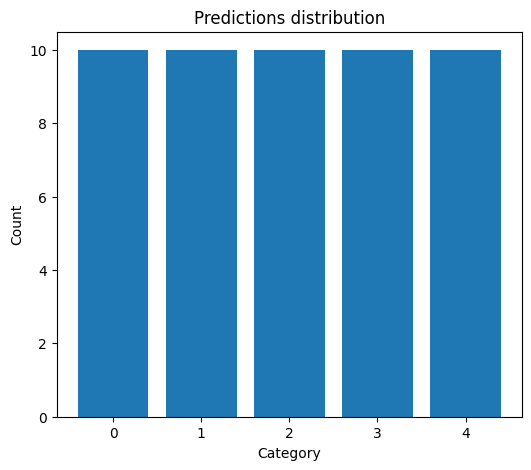

Submission file submission.csv created


In [20]:
submission(y_pred, "submission", plot=True)